# Convolutiona Neural Networks (CNN)

When dealing with images, pixels are the input features to a Neural Network. Right away, we recognize two things about pixels:
1. Pixels close to each other are related to each other
2. There can be a very, very large number of pixels in an image

So, due to these two observations, we use **convolutional** neural networks when we deal with machine vision (which is a fancy name for applying machine learning and/or any other form of sritifical intelligence on images, or videos, which are a bunch of images).  

If you do not remember what convolution is, that's OK. All you need to know is that convolution maps your input to another domain, does some operation there to condense the data representation, then brings this daa back to the domain where it started.   
This is great news for us because it means we can:
* reduce the number of inputs (which reduces the time and computational power needed) AND
* not lose important relationships/data due to this reduction.

## What does my pipeline look like?

* Mix of:
  * Convolution
  * Pooling (reducing n*n pixels to a single pixel by max, min or avg)
* Followed by:
  * Flattening last output of pooling into standard 1 dimensinal features (input layer)
  * Normal hidden layers of neural network
  * Output layer


![MNIST network structure](https://miro.medium.com/max/1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

## Our example

The MNIST handwritten digit classification problem is a standard dataset used in computer vision and deep learning.

**MNIST** is an acronym that stands for the Modified National Institute of Standards and Technology dataset.

It is a dataset of 60,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.

The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively.

![MNIST examples](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

> Tutorial adapted from [How to Develop a CNN for MNIST Handwritten Digit Classification by Jason Brownlee](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/).

## 0. Let's familiarize ourselves with the data

`Tensorflow`'s `keras` conviniently packages the MNIST dataset to us as a class under `tensorflow.keras.datasets`. So, we can simply import it and use to to get training and testing sets. Then, we can use `matplotlib`'s `imshow()` to visualize some images from MNIST.

11490434/11490434 [==============================] - 1s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


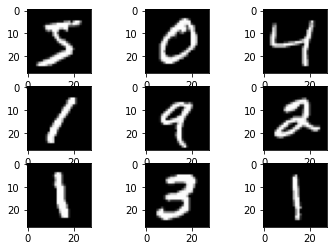

In [1]:
# example of loading the mnist dataset
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
 
	# plot raw pixel data
	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
 
# show the figure
plt.show()

### Using functions

In this tutorial, we will split our tasks into functions:
* `load_dataset()`: load train and test dataset
* `prep_pixels(train, test)`: scale pixels
* `define_model()`: define cnn model
* `evaluate_model(dataX, dataY, n_folds=5)`: evaluate a model using k-fold cross-validation
* `summarize_diagnostics(histories)`: plot diagnostic learning curves
* `summarize_performance(scores)`: summarize model performance
* `run_test_harness()`: run the test harness for evaluating a model

Using functions makes our code modular, which can help us:
* isolate a bug in a certain step
* let a third-party library handle a certain part of our pipeline
* analyse the performance bottlenecks of our pipeline
* test the different steps of our pipeline

In [2]:
# load all necessary libraries
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

## 1. Load dataset

We already know that:
* the images are all pre-aligned
* all images have same size (28x28 pixels)
* the images are grayscale
* there are 10 classes, each represented as aunique integer

Thus, let's load the images and reshape them to have a single color channel (less load on memory and computation and we only have grayscale anyway).

Also, let's use one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes.

In [3]:
# load train and test dataset
def load_dataset():
  print('Loading dataset..')

  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()

  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))

  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)

  return trainX, trainY, testX, testY

## 2. Prepare pixel data

We know that the pixels are all grayscale, which means that each pixel has a value between 0 and 255.

So, we normalize them to have values between 0 and 1. This makes our model more generalizable in the future: if case the pixel data is not between 0 and 255, we can simply scale it to be between 0 and 1.

In [4]:
# scale pixels
def prep_pixels(train, test):
  print('Normalizing pixels..')

  # convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')

  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0

  # return normalized images
  return train_norm, test_norm

## 3. Define model

Our model will have two main components:

1. feature extraction front-end: 

  * [convolutional layer](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/)
  * [max pooling layer](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/)

2. classifier back-end (to make predictions):

* dense (hidden) layer
* output layer of 10 nodes (since we have 10 classes)

All layers will use the [ReLU activation function](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) and the He weight initialization scheme, both best practices.

> Output layer will use the softmax function, which is a multi-class version of sigmoid (sigmoid can only support 2 classes, a.k.a. binary problems).

We will use a conservative configuration for the stochastic gradient descent optimizer with a [learning rate](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/) of 0.01 and a momentum of 0.9. The [categorical cross-entropy](https://machinelearningmastery.com/cross-entropy-for-machine-learning/) loss function will be optimized, suitable for multi-class classification, and we will monitor the classification accuracy metric, which is appropriate given we have the same number of examples in each of the 10 classes.

In [5]:
# define cnn model
def define_model():
  print('Defining model..')

  # initialize empty sequential model
  model = Sequential()

  # add a 2D convolutional layer with:
  # - 32 filters 
  # - filter size 3x3
  # - relu activation function
  # - he_uniform initilizer
  # - input is 28x28 with a single channel
  model.add(Conv2D(32, 
                  (3, 3), 
                  activation='relu', 
                  kernel_initializer='he_uniform', 
                  input_shape=(28, 28, 1)))

  # add a 2D max pooling layer that takes the max of a
  # -  2x2 square
  model.add(MaxPooling2D((2, 2)))

  # flatten the output of the pooling to become input to a neural network
  model.add(Flatten())

  # add a hidden layer with:
  # - 100 nodes
  # - relu activation function
  # - he_uniform initilizer
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))

  # add a the output layer to:
  # - use a softmax activation function and 
  # - output the probabilities of 10 classes
  model.add(Dense(10, activation='softmax'))

  # compile the model with:
  # - stochastic gradient descent optimizer with:
  # -- learning rate of 0.01
  # -- momentum of 0.9
  # - categorical cross entropy loss function
  # - keep track of accuracy
  model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

  return model

## 4. Evaluate model

We will use 5-**cross-validation** so we keep our testing data completely unkown to the model till the final testing.

The training dataset is **shuffled** prior to being split, and the sample shuffling is performed each time, so that any model we evaluate will have the same train and test datasets in each fold, providing an apples-to-apples comparison between models.

In [6]:
# evaluate a model using k-fold cross-validation
# - have a default of 5 folds
def evaluate_model(dataX, dataY, n_folds=5):
  print('Evaluating model..')
  
  # inilialize empty lists to keep track of scores and histories
  scores, histories = list(), list()

  # prepare cross validation with:
  # - 5 folds
  # - random state = 1 (to get same results everytime)
  # - shuffling ON
  kfold = KFold(n_folds, shuffle=True, random_state=1)

  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):

    # define model
    model = define_model()

    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    
    # fit model with:
    # - 10 epochs (relatively low number)
    # - 32 batch size (default)
    # - set verbose to 0 to keep console output quiet
    # - testX and textY as validation data
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, 
                        validation_data=(testX, testY), verbose=0)
    
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))
    
    # stores scores and histories
    scores.append(acc)
    histories.append(history)

  return scores, histories

## 5. Present results

There are 2 key aspects to present:
* diagnostics of learning behavior during training
* estimation of performance
We will have a separate function for each.

First, for the diagnostics, we are always interested in the evolution of two things:

* **loss** (a.k.a. error)
* **accuracy**  

both against epochs.

Since we have 5 folds, we will overlay 5 curves on top of each other in each graph.


In [7]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  print('Summarizing diagnostics..')
  
  for i in range(len(histories)):

    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')

    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')

  plt.show()

Next, the classification accuracy scores collected during each fold can be summarized by calculating:
* **mean**: an estimate of the average expected performance of the model trained on this dataset
* **std dev**: an estimate of the average variance in the mean. 

We will also summarize the **distribution** of scores by creating and showing a **box and whisker plot**.

In [8]:
# summarize model performance
def summarize_performance(scores):
  print('Summarizing performance..')

  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % 
        (mean(scores)*100, std(scores)*100, len(scores)))
  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

## 6. Run everything to evaluate model

First, let's define a function that runs the entire test harness.

In [9]:
# run the test harness for evaluating a model
def run_test_harness():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()
  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # evaluate model
  scores, histories = evaluate_model(trainX, trainY)
  # learning curves
  summarize_diagnostics(histories)
  # summarize estimated performance
  summarize_performance(scores)

And finally, let's run everything!

Loading dataset..
Normalizing pixels..
Evaluating model..
Defining model..
> 98.608
Defining model..
> 98.667
Defining model..
> 98.667
Defining model..
> 98.808
Defining model..
> 98.683
Summarizing diagnostics..


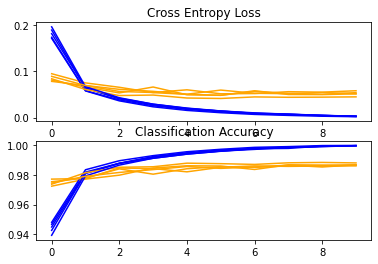

Summarizing performance..
Accuracy: mean=98.687 std=0.066, n=5


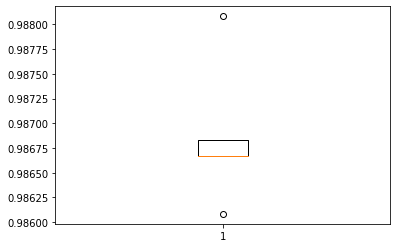

In [10]:
# entry point, run the test harness
# --> remember to go to Runtime > Change runtime type > Choose GPU
# took about 7 minutes
run_test_harness()

## 7. Possible Improvements

* Learning rate
* [Batch normalization](https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/)
* Increase in model depth
  * capacity of feature extraction
    * more convolutional layers with more filters
    * often followed by more pooling
  * capacity of classifier

> Look at [the poriginal tutorial](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/) to see the implementation of these improvements.

## 8. Save model

Models take a lot of time and resources to train. Thus, you will probably want to save a copy of your model once it is done training so you can use it to predict right away in the future.

We often save such model to H% files, a data file saved in the Hierarchical Data Format (HDF). This contains multidimensional arrays of scientific data.

> Taken from [FileInfo.com](https://fileinfo.com/extension/h5#:~:text=An%20H5%20file%20is%20a,electronics%20instruments%2C%20and%20medical%20fields.)

In [11]:
# make a model and save it to provided filename
def fit_and_save_model(filename):
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # define model
    model = define_model()
    # fit model
    model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
    # save model
    model.save(filename)
 
fit_and_save_model('final_model.h5')

Loading dataset..
Normalizing pixels..
Defining model..


## 9. Make prediction

Now, we never have to wait for the preparation of the data or for thje model to train. All we have to do is load the `.h5` file into a model and use it to predict the class of an image.

For example, let's use our model to try and predict this image of a hand-written `7`.

<center>

![MNIST 7](https://machinelearningmastery.com/wp-content/uploads/2019/02/sample_image-300x298.png)

</center>

In [13]:
# import necessary functions
from numpy import argmax
from keras.utils import load_img, img_to_array
from keras.models import load_model

Recall that we reshaped our 28x28 image to have only a single channel. Then, we normalized the pixel values to be between 0 and 1. We must do the same now everytime we want to pass an image to the pipeline.

In [14]:
# load and prepare the image
def load_image(filename):

  # load the image
  img = load_img(filename, color_mode='grayscale', target_size=(28, 28))

  # convert to array
  img = img_to_array(img)

  # reshape into a single sample with 1 channel
  img = img.reshape(1, 28, 28, 1)

  # prepare pixel data (a.k.a. normalize)
  img = img.astype('float32')
  img = img / 255.0

  return img

In [18]:
# load an image and predict the class
def run_example():
  # load the image
  img = load_image('/content/sample_image.png')

  # load model
  model = load_model('/content/final_model.h5')

  # predict the class
  predict_value = model.predict(img)
  
  # use argmax to get the index of the class with the highest probability
  digit = argmax(predict_value)
  
  print(digit)

In [23]:
# entry point, run the example
run_example()

1/1 [==============================] - 0s 116ms/step
7
